In [1]:
device = "cuda"

In [ ]:
# load model

from transformers import AutoModelForCausalLM, AutoTokenizer
model_name = "gpt2-medium"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

/home/cass/anaconda3/envs/eva/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-25 14:54:25.617334: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-25 14:54:25.839339: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-25 14:54:26.714023: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not 

: 

: 

In [ ]:
from rationalizer.aggregate_rationalizer import AggregateRationalizer
from rationalizer.importance_score_evaluator.delta_prob import DeltaProbImportanceScoreEvaluator
from rationalizer.stopping_condition_evaluator.top_k import TopKStoppingConditionEvaluator
from rationalizer.token_replacement.token_replacer.uniform import UniformTokenReplacer
from rationalizer.token_replacement.token_sampler.postag import POSTagTokenSampler

# construct rationalizer

rational_size = 5
rational_size_ratio = None

token_sampler = POSTagTokenSampler(tokenizer=tokenizer, device=device)

stopping_condition_evaluator = TopKStoppingConditionEvaluator(
    model=model, 
    token_sampler=token_sampler, 
    top_k=10, 
    top_n=rational_size, 
    top_n_ratio=rational_size_ratio, 
    tokenizer=tokenizer
)

importance_score_evaluator = DeltaProbImportanceScoreEvaluator(
    model=model, 
    tokenizer=tokenizer, 
    token_replacer=UniformTokenReplacer(
        token_sampler=token_sampler, 
        ratio=0.3
    ),
    stopping_condition_evaluator=stopping_condition_evaluator,
    max_steps=3000
)

rationalizer = AggregateRationalizer(
    importance_score_evaluator=importance_score_evaluator,
    batch_size=5,
    overlap_threshold=2,
    overlap_strict_pos=True,
    top_n=rational_size, 
    top_n_ratio=rational_size_ratio
)


[POSTagTokenSampler] Loading vocab from tokenizer - 0.00%
[POSTagTokenSampler] Loading vocab from tokenizer - 9.95%
[POSTagTokenSampler] Loading vocab from tokenizer - 19.90%
[POSTagTokenSampler] Loading vocab from tokenizer - 29.85%
[POSTagTokenSampler] Loading vocab from tokenizer - 39.80%
[POSTagTokenSampler] Loading vocab from tokenizer - 49.74%
[POSTagTokenSampler] Loading vocab from tokenizer - 59.69%
[POSTagTokenSampler] Loading vocab from tokenizer - 69.64%
[POSTagTokenSampler] Loading vocab from tokenizer - 79.59%
[POSTagTokenSampler] Loading vocab from tokenizer - 89.54%
[POSTagTokenSampler] Loading vocab from tokenizer - 99.49%


In [52]:
input_string = "When my flight landed in Thailand. I was staying in the capital city of"

max_length = 25

# generate prediction 
input_ids = tokenizer(input_string, return_tensors='pt')['input_ids'][0].to(model.device)
generated_ids = model.generate(input_ids=torch.unsqueeze(input_ids, 0), max_length=max_length, do_sample=False)[0]
generated_texts = [ tokenizer.decode(token) for token in generated_ids ]
print(f'generated full sequence --> {generated_texts}')

import torch

# rationalize each generated token

importance_scores = []
importance_score_map = torch.zeros([generated_ids.shape[0] - input_ids.shape[0], generated_ids.shape[0] - 1])

for target_pos in torch.arange(input_ids.shape[0], generated_ids.shape[0]):
    # extract target
    target_id = generated_ids[target_pos]

    # rationalization
    pos_rational = rationalizer.rationalize(torch.unsqueeze(generated_ids[:target_pos], 0), torch.unsqueeze(target_id, 0))[0]

    ids_rational = generated_ids[pos_rational]
    text_rational = [ tokenizer.decode([id_rational]) for id_rational in ids_rational ]

    importance_score_map[target_pos - input_ids.shape[0], :target_pos] = rationalizer.mean_important_score

    print(f'{target_pos} / {generated_ids.shape[0]}')
    print(f'Target word     --> {tokenizer.decode(target_id)[0]}', )
    print(f"Rational pos    --> {pos_rational}")
    print(f"Rational text   --> {text_rational}")

    print()


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


generated full sequence --> ['When', ' my', ' flight', ' landed', ' in', ' Thailand', '.', ' I', ' was', ' staying', ' in', ' the', ' capital', ' city', ' of', ' Bangkok', '.', ' I', ' was', ' in', ' a', ' hotel', ' room', ' with', ' my']
15 / 25
Target word     -->  
Rational pos    --> tensor([ 0,  2,  4,  5,  8, 12, 13, 14], device='cuda:0')
Rational text   --> ['When', ' flight', ' in', ' Thailand', ' was', ' capital', ' city', ' of']

16 / 25
Target word     --> .
Rational pos    --> tensor([ 0,  1,  4,  6,  8,  9, 10, 13, 15], device='cuda:0')
Rational text   --> ['When', ' my', ' in', '.', ' was', ' staying', ' in', ' city', ' Bangkok']

17 / 25
Target word     -->  
Rational pos    --> tensor([ 1,  5,  7,  8,  9, 13, 15, 16], device='cuda:0')
Rational text   --> [' my', ' Thailand', ' I', ' was', ' staying', ' city', ' Bangkok', '.']

18 / 25
Target word     -->  
Rational pos    --> tensor([ 0,  2,  5,  6,  7,  9, 15, 16], device='cuda:0')
Rational text   --> ['When', ' flight

In [46]:
import seaborn
import matplotlib.pyplot as plt
import csv
import pandas as pd
import torch
import numpy

In [7]:
myFile = open('../../visual/out.csv', 'r')
reader = csv.reader(myFile)
importance_score_map = []
for record in reader:
    importance_score_map.append(record)
print("The list of lists is:")
print(importance_score_map)

The list of lists is:
[['0.1238761693239212', '0.1986209899187088', '0.10781191289424896', '0.15047204494476318', '0.11598412692546844', '0.14737066626548767', '0.15586408972740173', '0.0', '0.0'], ['0.10409853607416153', '0.1285756528377533', '0.0647372156381607', '0.1160430759191513', '0.14496929943561554', '0.1700899302959442', '0.1485416144132614', '0.12294463068246841', '0.0'], ['0.1075095385313034', '0.09505584836006165', '0.1176433339715004', '0.1295018494129181', '0.08424704521894455', '0.0807812437415123', '0.12144855409860611', '0.17954066395759583', '0.0842718854546547']]


In [14]:
df = pd.read_csv('../../visual/out.csv', header=None)

,0,1,2,3,4,5,6,7,8
0,0.123876,0.198621,0.107812,0.150472,0.115984,0.147371,0.155864,0.000000,0.000000
1,0.104099,0.128576,0.064737,0.116043,0.144969,0.170090,0.148542,0.122945,0.000000
2,0.107510,0.095056,0.117643,0.129502,0.084247,0.080781,0.121449,0.179541,0.084272


In [47]:
importance_score_map = [df.loc[0].to_list(), df.loc[1].to_list(), df.loc[2].to_list()]
importance_score_map = torch.FloatTensor(importance_score_map)
mask_bloo = importance_score_map == 0

importance_score_map =numpy.array([numpy.array(xi) for xi in importance_score_map])
mask_bloo =numpy.array([numpy.array(xi) for xi in mask_bloo])

In [81]:
generated_texts = ["Model","explanation","is","a","difficult", "thing", "to", "do"]

In [ ]:
fig, ax = plt.subplots()
ax.imshow(dat, interpolation='none')
fig.colorbar(ax.images[0], ax=ax)
fig.axes[1].set(title='This is a title', xlabel='caption', ylabel='colors');

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

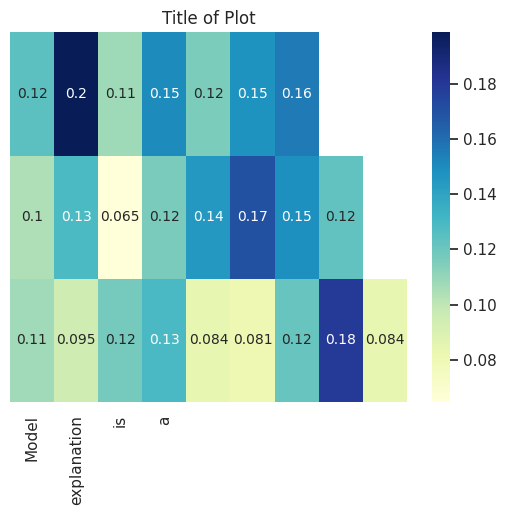

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
heatmap = sns.heatmap(importance_score_map, annot=True, annot_kws={'fontsize':10}, cmap="YlGnBu", mask=mask_bloo, 
                    xticklabels = generated_texts[:-1],
                    yticklabels = generated_texts[len(generated_texts):],
                    cbar_kws = dict(use_gridspec=False)).set(title='Title of Plot')

plt = plt.colorbar()
plt.ax.set_title('Importance')
plt.show()
 #vmin=-1, vmax=1, 

 done


<AxesSubplot:title={'center':'Model GPT2'}, xlabel='Prompt(Input)', ylabel='Predicted Word'>

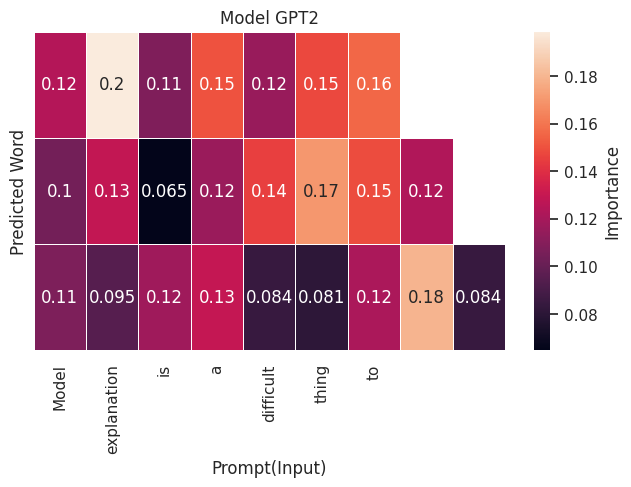

In [84]:

#seaborn.set(rc={ 'figure.figsize': (30, 10) })

# cmap = plt.cm.get_cmap('Reds').copy()
# cmap.set_bad('midnightblue')      # color of mask on heatmap
# cmap.set_under('midnightblue')  

s = sns.heatmap(
    importance_score_map, 
    xticklabels=generated_texts[:-1], 
    yticklabels=generated_texts[len(generated_texts):], 
    annot=True, 
    mask=mask_bloo, 
    linewidth=.5,
    cbar_kws={'label': 'Importance'}
    )

#axs.set(xlabel="Importance distribution", ylabel="Target")
plt.title(f'Model GPT2')

#axs.xaxis.tick_top()
#s.set_axis_labels('Total Bill Amount ($)')
plt.tight_layout()
#s.set(xlabel="Importance distribution", ylabel="Target")
#s.set_xlabel('Importance distribution')
s.set_ylabel('Predicted Word')
s.set_xlabel('Prompt(Input)')

scatter_fig = s.get_figure()



scatter_fig.savefig('../../visual/t2.png')
print(' done')
s